In [1]:
## CALCULATE ERRORS

import pandas as ps
import numpy as np
import itertools
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from scipy import optimize

#c8 = ['#000000', '#E69F00', '#56B4E9', '#009E73', '#D55E00', '#0072B2', '#CC79A7','#F0E442']
c8 = ['#000000', '#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7']
#c8 = ['#000000', '#0072B2', '#009E73', '#D55E00', '#56B4E9', '#CC79A7', '#E69F00', '#F0E442']
#c8 = [(0,0,0), (230,159,0), (86,180,233), (0,158,115), (240,228,66), (0,114,178), (213,94,0),(204,121,167)]

def angle_between(v1, v2):

    if np.isnan(v1).any() or np.isnan(v2).any():
        return np.NaN
    else:
        angle = np.math.atan2(np.linalg.det([v1,v2]),np.dot(v1,v2))
        angle = (angle < 0) * 2 *np.pi + angle
        
        return angle

    
def angle_between_err(v1, v2, err1, err2, verbose=False):


    if np.isnan(v1).any() or np.isnan(v2).any():
        return np.NaN, np.NaN
    else:

        #angle = np.math.atan2(np.linalg.det([v1,v2]),np.dot(v1,v2))
        #angle = (angle < 0) * 2 *np.pi + angle
        angle=angle_between(v1, v2)

        a=np.array([1,-1])
        b=np.array(list(itertools.product(a,repeat=2)))
        #print(b)
        angle2=[]
        for berr in b:
            for cerr in b:
                va=np.abs(v1+berr*err1)*np.sign(v1)
                vb=np.abs(v2+cerr*err2)*np.sign(v2)
                angle2.append(angle_between(va, vb))
                if verbose:
                    print(berr,cerr,berr*err1,cerr*err2)
                    print(v1,v2,angle)
                    print(va,vb,angle_between(va, vb))
        angle2=np.array(angle2)
        angle2[angle-angle2>np.pi]=2*np.pi-angle2[angle-angle2>np.pi]
        error=np.mean(np.abs(angle-angle2))
        #print(np.mean(np.abs(angle-angle2)))
        error2=np.max(np.abs(angle-angle2))
        if verbose: 
            print(angle,error)
            print(angle,error2)

        return angle, error


def dist_angle(df,df2,pjs,pix_to_deg):

    cols = df.columns
    dirfac=np.array([1,-1])

    for ipj,pj in enumerate(pjs):
        # polar vector
        xpol = df2.loc[(pj,'mean'),cols[0]]
        ypol = df2.loc[(pj,'mean'),cols[1]]
        err_p  = 30*0.3
        vpol = np.array([xpol,ypol])
        
        
        # vector pointing from pole to south-polar L=0 in System III
        vp2  = np.array([xpol-100,ypol])
        vpxx = np.array([-100,0])# vp2 - vpol 

        # CPC0 vector
        xc0 = df2.loc[(pj,'mean'),cols[2]]
        yc0 = df2.loc[(pj,'mean'),cols[3]]
        isg = df2.loc[(pj,'is.good'),cols[2]]
        if np.isnan(isg): isg=0
        #print(isg)
        err_c = 10 + 40*(1-isg)
        vc0 = np.array([xc0,yc0])
        
        # vector pointing from CPC0 to south-polar L=0 in System III
        vc2 = np.array([xc0-100,yc0])
        vcxx = np.array([-100,0])# vc2 - vc0 

        for icol in np.arange(0,len(cols),2):
            # coordinates 
            xcoord=df2.loc[(pj,'mean'),cols[icol]]
            ycoord=df2.loc[(pj,'mean'),cols[icol+1]]
            isg = df2.loc[(pj,'is.good'),cols[icol]]
            #if np.isnan(isg): isg=0
            err_x = 10 + 40*(1-isg)

            df2.loc[(pj,'mean.x'),cols[icol][0:4]]=xcoord
            df2.loc[(pj,'mean.y'),cols[icol][0:4]]=ycoord

            # copy is.good
            df2.loc[(pj,'is.good'),cols[icol][0:4]]=df2.loc[(pj,'is.good'),cols[icol]]
            
            # vector cyclone
            vc=np.array([xcoord,ycoord])
            
            # vector pole to cyclone
            vcp=(vc-vpol)*dirfac
            
            # vector central CPC to cyclone
            vcc=(vc-vc0)*dirfac

            df2.loc[(pj,'distance from pole'),cols[icol][0:4]]=np.linalg.norm(vcp)*pix_to_deg[ipj]
            df2.loc[(pj,'distance from CPC0'),cols[icol][0:4]]=np.linalg.norm(vcc)*pix_to_deg[ipj]
            df2.loc[(pj,'error distance from pole'),cols[icol][0:4]]=(   np.sqrt((pow(10,2)+ pow(err_p+40*(1-isg),2) )/2 ) )*pix_to_deg[ipj] #/2 because +/- error
            df2.loc[(pj,'error distance from CPC0'),cols[icol][0:4]]=(  np.sqrt((pow(10,2)+ pow(40*(1-isg),2) )/2        )  )*pix_to_deg[ipj]
            #print(ipj,cols[icol],((10+err_p+40*(1-isg)))/2*pix_to_deg[ipj],((10+40*(1-isg)))/2*pix_to_deg[ipj] )
            
            verb=False
            angle_p, error_p = angle_between_err(vpxx, vcp, err_p, err_x, verb)
            angle_c, error_c = angle_between_err(vcxx, vcc, err_c, err_x, verb)
            aix=0
            if pj==1 or pj==5: aix=1.5 #1.5 degree rotation for PJ 1 and 5 to account for corrected pointing forx the images
            ap=angle_p/np.pi*180 + aix
            ac=angle_c/np.pi*180 + aix
            df2.loc[(pj,'angle from pole'),cols[icol][0:4]]=ap
            df2.loc[(pj,'angle from CPC0'),cols[icol][0:4]]=ac
            df2.loc[(pj,'error angle from pole'),cols[icol][0:4]]=error_p/np.pi*180
            df2.loc[(pj,'error angle from CPC0'),cols[icol][0:4]]=error_c/np.pi*180    

    return df2.sort_index()


def plot_cpc_err_old(df,dg,dferr,title='Angle from central CPC (System III)',name=''):

    cols=df.columns.values.tolist()

    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    colors = c8[1:8] #list(mcolors.BASE_COLORS)
    
    for icol, col in enumerate(cols):    
        ax1.plot(df[col],color=colors[icol])  
        ax1.errorbar(df.index, df.iloc[:,icol].values, yerr=dferr.iloc[:,icol].values,color=colors[icol])
        ax1.scatter(dg.index, dg.iloc[:,icol].values,color=colors[icol],marker='s')
        
    ax1.set_ylabel(title)
    ax1.set_xlabel('PJ') 
    ax1.legend(cols,loc=0)   
    ax2=make_day_axis(ax1,fig1)
        #(dg5[~dg5['CPC1'].isnull()]).plot.scatter()
        #ax1.scatter(dg5[~dg5['CPC1'].isnull()])
    fig1.savefig('CPC_all'+name+'.png',dpi=200)


    
    for icol, col in enumerate(cols):
        x = df.index
        A = np.vstack([x, np.ones(len(x))]).T
        m, c = np.linalg.lstsq(A, df.iloc[:,icol].fillna(method='ffill').values, rcond=None)[0]
        
        

        
        
        fig1 = plt.figure()
        ax1 = fig1.add_subplot(111)
        ax1.plot(df[col],color=colors[icol])
        ax1.scatter(dg.index, dg.iloc[:,icol].values,color=colors[icol])
        ax1.errorbar(df.index, df.iloc[:,icol].values, yerr=dferr.iloc[:,icol].values,color=colors[icol])
        
        ax1.plot(df.index,m*df.index+c,color=colors[icol],linestyle=':')
        #v_drift = (df[col].values[-1]-df[col].values[0])/(df.index[-1]-1)
        #v_drift = m
        
        print(m)
        print(col)
        title_drift=col+r' $v_{drift}=$'+str(np.round(m,2))+' deg/PJ' 
        ax1.set_title(title_drift)
        ax1.set_ylabel(title)
        ax1.set_xlabel('PJ')
        ax2=make_day_axis(ax1,fig1)
        fig1.savefig('CPC_'+col+name+'.png',dpi=200)

def make_nice(df3,qstr):
    df4=df3.query(qstr).copy()
    df4=df4.drop(columns=['pole'])
    df4=df4.drop(columns=['CPC0'])
    df4[df4>340]-=360
    df4=df4.reset_index()
    df4=df4.drop(columns=['location'])
    #df4=df4.drop(columns=['index'])
    df4=df4.set_index('PJ')
    return df4


def make_n(dx2,qstr):
    dx=dx2.query(qstr)
    dx=dx.reset_index()
    dx=dx.drop(columns=['location'])
    dx=dx.set_index('PJ')
    dx=dx.sort_index()
    return dx

def make_day_axis(ax1,fig1,set_xlim=True):
    ax2 = ax1.twiny()

    fig1.subplots_adjust(bottom=0.2)

    pjmax=pjs[-1]
    new_tick_locations = np.array([0,1,2,3,4,5])/5.0 *(pjmax-1)/(pjmax) + 1/(2*pjmax) #*(pjmax-1)/(pjmax)   #*(pjmax)*(pjmax-1)+1/(2*pjmax)
    print(new_tick_locations)
    #new_tick_locations = new_tick_locations / 8.0+0.05 #16.0+0.05
    new_tick_labels = ['0','150','300','450','600','750']#['0','100','200','300','400','500','600','700']
    #new_tick_locations2= new_tick_locations/53.5/16.0-1/16.0/2
    def tick_function(X):
        V = (X)*53.5*16#+53.5/2
        return ["%.0f" % z for z in V]
    if set_xlim: ax1.set_xlim(0.5, 15.5)

    ttl = ax1.title
    ttl.set_position([.5, 0.89])
    
    # Move twinned axis ticks and label from top to bottom
    ax2.xaxis.set_ticks_position("top")
    ax2.xaxis.set_label_position("top")

    # Offset the twin axis below the host
    #ax2.spines["bottom"].set_position(("axes"))#, -0.16))
    ax2.spines["bottom"].set_position(("axes",0))
    # Turn on the frame for the twin axis, but then hide all 
    # but the bottom spine
    ax2.set_frame_on(True)
    ax2.patch.set_visible(False)
    #for sp in ax2.spines.itervalues():
    #    sp.set_visible(False)
    ax2.spines["bottom"].set_visible(True)

    ax2.set_xticks(new_tick_locations)
    #ax2.set_xticklabels(tick_function(new_tick_locations))
    ax2.set_xticklabels(new_tick_labels)
    ax2.set_xlabel("days since first approach at PJ1")
    return ax2

In [2]:
# indexing help
# https://pandas.pydata.org/pandas-docs/stable/indexing.html

# Read in CPC_locations.xlsx sheet_name='coordinates2' 
df=ps.read_excel('/Users/tabataba/Documents/CPC_locations.xlsx','coordinates3')
# Remove the extra column 'Unnamed: 0'
df = df.drop('Unnamed: 0',axis=1)
# set primary index to PJ and secondary index to location
df = df.set_index(['PJ','location'])

pjs = [1,3,4,5,6,7,8,9,10,11,12,13,14,15]
npj=len(pjs)

pd1 = 1.0/40
pd2 = 1.0/30
pd15= 1.0/30
pix_to_deg1 = [pd1,pd1,pd1,pd1,pd1,pd1,pd1,pd1,pd2,pd2,pd2,pd2,pd2,pd15]

print(df.columns)
print(df.index.levels[0])

#calculate mean value 
# for each perijove 
for pj in pjs:
    # for each column 
    for col in df.columns:
        # calculate the mean coordinate value for each location and set it as the sublabel mean
        df.loc[(pj,'mean'),col]=np.mean(df.loc[pj,col][0:14])
#sort the new mean values according to index PJ
df=df.sort_index()

df.head()

# Query only mean and is.good for each PJ
df2=df.query('location == "mean" | location == "is.good"').copy()
df2.head()

# Add distance and angle to df2
df2=dist_angle(df,df2,pjs,pix_to_deg1)

# remove
colsofinterest=['pole','CPC0','CPC1','CPC2','CPC3','CPC4','CPC5']#df2.columns[14:21]
#print(colsofinterest)
df3=df2[colsofinterest]
for pj in pjs:
    df3=df3.drop((pj,'mean'))
df3.head()

df4=make_nice(df3,'location == "angle from pole"')
#print(df4)
#df4.fillna(method='ffill').plot()
#plt.title('Angle from South Pole (System III)')

df5=make_nice(df3,'location == "angle from CPC0"')
#print(df5)
#df5.fillna(method='ffill').plot()
#plt.title('Angle from central CPC (System III)')

Index(['pole.x', 'pole.y', 'CPC0.x', 'CPC0.y', 'CPC1.x', 'CPC1.y', 'CPC2.x',
       'CPC2.y', 'CPC3.x', 'CPC3.y', 'CPC4.x', 'CPC4.y', 'CPC5.x', 'CPC5.y',
       'AWO1.x', 'AWO1.y', 'AWO2.x', 'AWO2.y', 'Unnamed: 21', 'Unnamed: 22'],
      dtype='object')
Int64Index([1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], dtype='int64', name='PJ')


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [3]:
# REDO with JIRAM data
import matplotlib.pyplot as plt

dg=ps.read_excel('/Users/tabataba/Documents/CPC_locations.xlsx','jiram_coordinates3')
dg = dg.drop('Unnamed: 0',axis=1)
dg = dg.set_index(['PJ','location'])
pjs2=[4,5]

#print(dg)

for pj in pjs2:
    # for each column 
    for col in dg.columns:
        # calculate the mean coordinate value for each location and set it as the sublabel mean
        dg.loc[(pj,'mean'),col]=np.mean(dg.loc[pj,col][0:14])
dg=dg.sort_index()
dg2=dg.query('location == "mean" | location == "is.good"').copy()

pix_to_deg2 = [1.0/77.3, 1.0/57]
dg2=dist_angle(dg,dg2,pjs2,pix_to_deg2)

colsofinterest=['pole','CPC0','CPC1','CPC2','CPC3','CPC4','CPC5']
dg3=dg2[colsofinterest]
for pj in pjs2:
    dg3=dg3.drop((pj,'mean'))  

dg4=make_nice(dg3,'location == "angle from pole"')
#print(dg4)
#dg4.fillna(method='ffill').plot()
#plt.title('Angle from South Pole (System III)')   

dg5=make_nice(dg3,'location == "angle from CPC0"')
#print(dg5)
#dg5.fillna(method='ffill').plot()
#plt.title('Angle from central CPC (System III)')

dg6=make_nice(dg3,'location == "angle from pole"')
#print(dg6)
#dg6.fillna(method='ffill').plot()
#plt.title('Angle from pole (System III)')

dg0=dg3.query('location == "angle from pole"').copy()
dg0=dg0.drop(columns=['pole'])
#dg0=dg0.drop(columns=['CPC0']) # THIS IS THE DIFFERENCE
dg0[dg0>340]-=360
dg0=dg0.reset_index()
dg0=dg0.drop(columns=['location'])
dg0=dg0.set_index('PJ')
#dg0.fillna(method='ffill').plot()
#plt.title('Angle from pole (System III)')

#dg0=make_nice(dg3,'location == "angle from pole"')
#print(dg0)
#dg0.fillna(method='ffill').plot()
#plt.title('Angle from pole (System III)')


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [4]:
dx3=dist_angle(df,df2,pjs,pix_to_deg1)
dx3

colsofinterest=['pole','CPC0','CPC1','CPC2','CPC3','CPC4','CPC5']
#print(colsofinterest)
dx3=df2[colsofinterest]
for pj in pjs2:
    dx3=dx3.drop((pj,'mean'))
    

dx=dx3.query('location == "angle from pole" | location == "error angle from pole" | location == "angle from CPC0" | location == "error angle from CPC0"').copy()
dx=dx.drop(columns=['pole'])
dx=dx.drop(columns=['CPC0'])
dx[dx>340]-=360
#dx=dx.reset_index()
#dx=dx.drop(columns=['location'])
#dx=dx.set_index('PJ')
dx=dx.sort_index()


dx0=dx3.query('location == "distance from pole" | location == "error distance from pole" | location == "distance from CPC0" | location == "error distance from CPC0" | location == "angle from pole" | location == "error angle from pole" | location == "angle from CPC0" | location == "error angle from CPC0"').copy()
dx0=dx0.drop(columns=['pole'])
dx0[dx0>340]-=360
#dx=dx.reset_index()
#dx=dx.drop(columns=['location'])
#dx=dx.set_index('PJ')
dx0=dx0.sort_index()




/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0.03333333 0.22       0.40666667 0.59333333 0.78       0.96666667]
1.5563205686993307 1.2187054744238348
CPC1
[0.03333333 0.22       0.40666667 0.59333333 0.78       0.96666667]
1.1498437036462255 1.8664380574475417
CPC2
[0.03333333 0.22       0.40666667 0.59333333 0.78       0.96666667]
1.3935436005440647 1.5061953349888189
CPC3
[0.03333333 0.22       0.40666667 0.59333333 0.78       0.96666667]
1.6045948223862943 1.4694518090509634
CPC4
[0.03333333 0.22       0.40666667 0.59333333 0.78       0.96666667]
1.2748419034176681 1.223206732178576
CPC5
[0.03333333 0.22       0.40666667 0.59333333 0.78       0.96666667]
[0.03333333 0.22       0.40666667 0.59333333 0.78       0.96666667]
1.6539015081288142 1.5879422241960581
CPC1
[0.03333333 0.22       0.40666667 0.59333333 0.78       0.96666667]
1.095814436224199 1.4018244142436123
CPC2
[0.03333333 0.22       0.40666667 0.59333333 0.78       0.96666667]
1.2957719502665075 1.7067168711973018
CPC3
[0.03333333 0.22       0.40666667 0.59333333 0

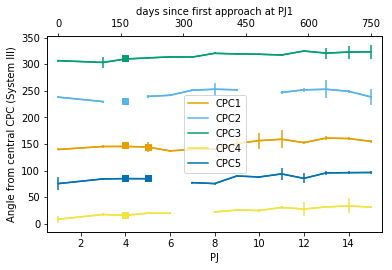

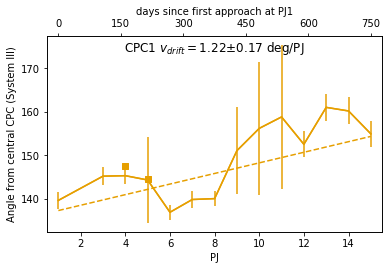

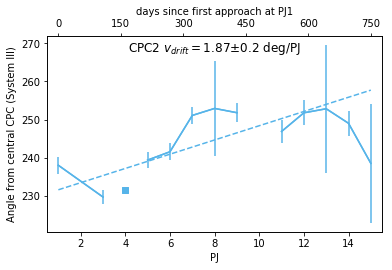

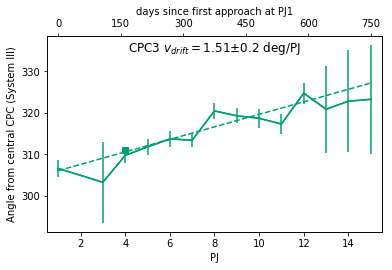

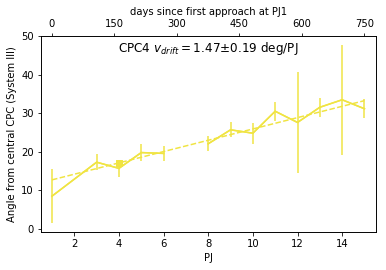

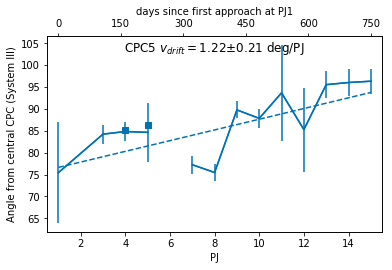

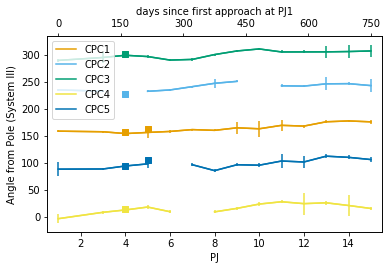

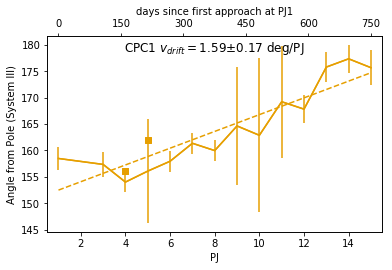

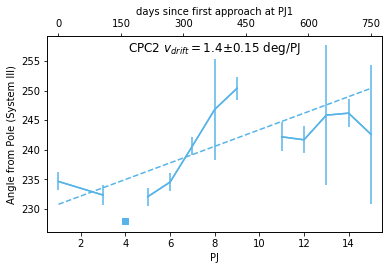

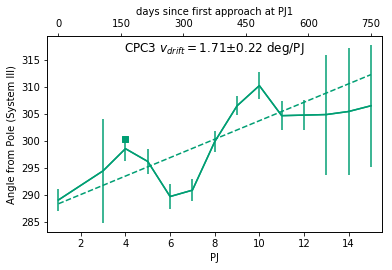

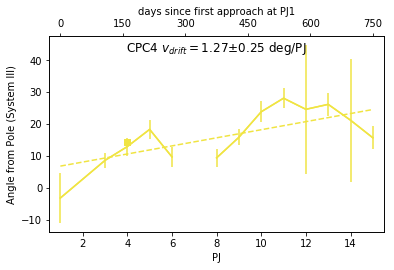

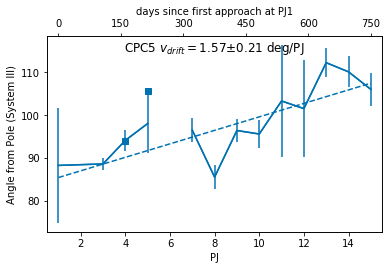

In [5]:


def plot_cpc_errx(df,dg,dferr,title='Angle from central CPC (System III)',name=''):

    cols=df.columns.values.tolist()

    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    colors = c8[1:8] #list(mcolors.BASE_COLORS)
    
    for icol, col in enumerate(cols):    
        ax1.plot(df[col],color=colors[icol])  
        ax1.errorbar(df.index, df.iloc[:,icol].values, yerr=dferr.iloc[:,icol].values,color=colors[icol])
        ax1.scatter(dg.index, dg.iloc[:,icol].values,color=colors[icol],marker='s')
        
    ax1.set_ylabel(title)
    ax1.set_xlabel('PJ') 
    ax1.legend(cols,loc=0) 
    ax2=make_day_axis(ax1,fig1)
    
       
        #(dg5[~dg5['CPC1'].isnull()]).plot.scatter()
        #ax1.scatter(dg5[~dg5['CPC1'].isnull()])
    fig1.savefig('CPC_all'+name+'.png',dpi=200)

    for icol, col in enumerate(cols):
        chi2=0
        chi3=0
        x = df.index
        A = np.vstack([x, np.ones(len(x))]).T
        m, c = np.linalg.lstsq(A, df.iloc[:,icol].fillna(method='ffill').values, rcond=None)[0]
        
        # This is a better plot with better chi squared
        fitfunc = lambda p, x: p[0] + p[1] * x
        errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err
        y1=df.iloc[:,icol].fillna(method='ffill').values
        y1err=dferr.iloc[:,icol].fillna(method='ffill').values
        
        pinit = [1.0, 1.0]
        
        out = optimize.leastsq(errfunc, pinit,
                               args=(x, y1, y1err), full_output=1)

        pfinal = out[0]
        covar = out[1]
        #print('hi')
        #print(pfinal)
        #print(covar)
        m2=pfinal[1]
        c2=pfinal[0]
        #print(m,c,m2,c2)
        mErr = np.sqrt( covar[1][1] )
        cErr = np.sqrt( covar[0][0] )
        #print(mErr,cErr)
        #[here]        
        
        fig1 = plt.figure()
        ax1 = fig1.add_subplot(111)
        ax1.plot(df[col],color=colors[icol])
        ax1.scatter(dg.index, dg.iloc[:,icol].values,color=colors[icol],marker='s')
        ax1.errorbar(df.index, df.iloc[:,icol].values, yerr=dferr.iloc[:,icol].values,color=colors[icol])
        
        #ax1.plot(df.index,m*df.index+c,color=colors[icol],linestyle=':')
        ax1.plot(df.index,pfinal[1]*df.index+pfinal[0],color=colors[icol],linestyle='--')
        for ipj, pj in enumerate(df.index):
            #print(float(df.iloc[ipj,icol])**2)
            if not np.isnan(df.iloc[ipj,icol]): chi2+=((m*pj+c)-(df.iloc[ipj,icol]))**2/(dferr.iloc[ipj,icol])**2
            if not np.isnan(df.iloc[ipj,icol]): chi3+=((m2*pj+c2)-(df.iloc[ipj,icol]))**2/(dferr.iloc[ipj,icol])**2
        
        #v_drift = (df[col].values[-1]-df[col].values[0])/(df.index[-1]-1)
        #v_drift = m
        
        print(m,m2)
        print(col)
        #title_drift=col+r' $v_{drift}=$'+str(np.round(m,2))+' deg/PJ '+str(np.round(m2,2))+r'$\pm$'+str(np.round(mErr,2))+' deg/PJ'+r',  $\chi^2=$'+str(np.round(chi2,2)) +'  '+str(np.round(chi3,2)) 
        title_drift=col+r' $v_{drift}=$'+str(np.round(m2,2))+r'$\pm$'+str(np.round(mErr,2))+' deg/PJ'#+r',  $\chi^2=$'+str(np.round(chi3,2)) 
        ax1.set_title(title_drift)
        ax1.set_ylabel(title)
        ax1.set_xlabel('PJ')
        ax2=make_day_axis(ax1,fig1)
        fig1.savefig('dCPC_'+col+name+'.png',dpi=200)
        
plot_cpc_errx(make_n(dx,'location == "angle from CPC0"'),dg5,make_n(dx,'location == "error angle from CPC0"'),title='Angle from central CPC (System III)',name='_angle_fromCPC0')
plot_cpc_errx(make_n(dx,'location == "angle from pole"'),dg6,make_n(dx,'location == "error angle from pole"'),title='Angle from Pole (System III)',name='_angle_frompole')
#HALLO

#plot_cpc(df,dg,title='Angle from South Pole (System III)')

[0.03333333 0.22       0.40666667 0.59333333 0.78       0.96666667]
[0.03333333 0.22       0.40666667 0.59333333 0.78       0.96666667]
[0.03333333 0.22       0.40666667 0.59333333 0.78       0.96666667]
[0.03333333 0.22       0.40666667 0.59333333 0.78       0.96666667]
[0.03333333 0.22       0.40666667 0.59333333 0.78       0.96666667]
[0.03333333 0.22       0.40666667 0.59333333 0.78       0.96666667]


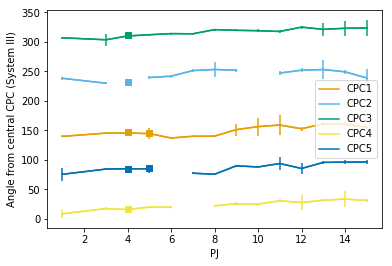

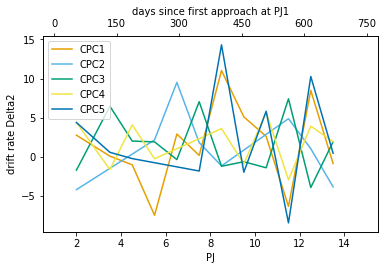

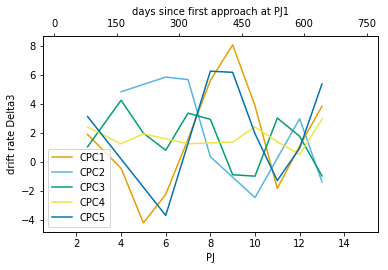

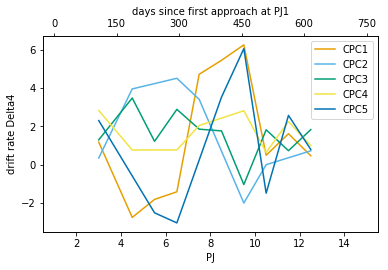

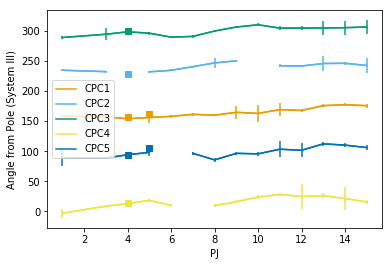

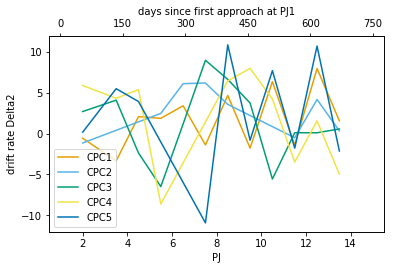

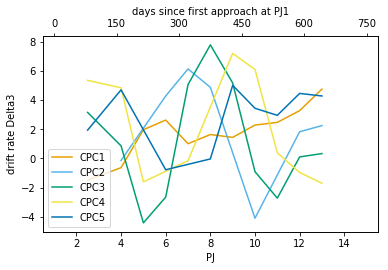

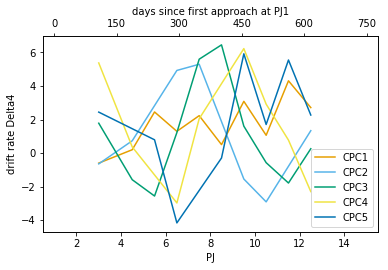

In [6]:
def plot_cpc_err2(df,dg,dferr,title='Angle from central CPC (System III)',name=''):

    cols=df.columns.values.tolist()
    dxx=df

    x1=[]
    x2=[]
    x3=[]
    x4=[]
    x5=[]

    for i,col in enumerate(cols):
        x1.append((dxx[col].values[(0+1):-1]-dxx[col].values[0:-(0+2)])/(dxx.index[1:-1]-dxx.index[0:-(0+2)]))
        x2.append((dxx[col].values[(1+1):-1]-dxx[col].values[0:-(1+2)])/(dxx.index[2:-1]-dxx.index[0:-(1+2)]))
        x3.append((dxx[col].values[(2+1):-1]-dxx[col].values[0:-(2+2)])/(dxx.index[3:-1]-dxx.index[0:-(2+2)]))
        x4.append((dxx[col].values[(3+1):-1]-dxx[col].values[0:-(3+2)])/(dxx.index[4:-1]-dxx.index[0:-(3+2)]))
        x5.append((dxx[col].values[(4+1):-1]-dxx[col].values[0:-(4+2)])/(dxx.index[5:-1]-dxx.index[0:-(4+2)]))

    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    colors = c8[1:8] # list(mcolors.BASE_COLORS)
    
    for icol, col in enumerate(cols):    
        ax1.plot(df[col],color=colors[icol])  
        ax1.errorbar(df.index, df.iloc[:,icol].values, yerr=dferr.iloc[:,icol].values,color=colors[icol])
        ax1.scatter(dg.index, dg.iloc[:,icol].values,color=colors[icol],marker='s')
        
        
    ax1.set_ylabel(title)
    ax1.set_xlabel('PJ') 
    ax1.legend(cols,loc=0)   

    j=0
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    ax1.set_ylabel('drift rate Delta2')
    ax1.set_xlabel('PJ') 
    colors = c8[1:8] # list(mcolors.BASE_COLORS)
    
    for i,col in enumerate(cols):
        index=(dxx.index[1:-1]+dxx.index[0:-2])/2
        xplot=x1[i]
        imask = np.isfinite(xplot)
        ax1.plot(index[imask],xplot[imask],color=colors[i])
    ax1.legend(cols,loc=0)  
    ax2=make_day_axis(ax1,fig1)
    fig1.savefig('drift_D1'+name+'.png',dpi=200)
    
    j=1
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    ax1.set_ylabel('drift rate Delta3')
    ax1.set_xlabel('PJ') 
    colors = c8[1:8] # list(mcolors.BASE_COLORS)
    
    for i,col in enumerate(cols):
        index=(dxx.index[(j+1):-1]+dxx.index[0:-(j+2)])/2
        xplot=x2[i]
        imask = np.isfinite(xplot)
        ax1.plot(index[imask],xplot[imask],color=colors[i])
    ax1.legend(cols,loc=0)
    ax2=make_day_axis(ax1,fig1)
    fig1.savefig('drift_D2'+name+'.png',dpi=200) 
        
    j=2
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    ax1.set_ylabel('drift rate Delta4')
    ax1.set_xlabel('PJ') 
    colors = c8[1:8] # list(mcolors.BASE_COLORS)
    for i,col in enumerate(cols):
        index=(dxx.index[(j+1):-1]+dxx.index[0:-(j+2)])/2
        xplot=x3[i]
        imask = np.isfinite(xplot)
        ax1.plot(index[imask],xplot[imask],color=colors[i])
    ax1.legend(cols,loc=0) 
    ax2=make_day_axis(ax1,fig1)
    fig1.savefig('drift_D3'+name+'.png',dpi=200)


plot_cpc_err2(make_n(dx,'location == "angle from CPC0"'),dg5,make_n(dx,'location == "error angle from CPC0"'),title='Angle from central CPC (System III)',name='angle_fromCPC0')
plot_cpc_err2(make_n(dx,'location == "angle from pole"'),dg6,make_n(dx,'location == "error angle from pole"'),title='Angle from Pole (System III)',name='angle_frompole')


[0.03333333 0.22       0.40666667 0.59333333 0.78       0.96666667]
[0.03333333 0.22       0.40666667 0.59333333 0.78       0.96666667]
[0.03333333 0.22       0.40666667 0.59333333 0.78       0.96666667]


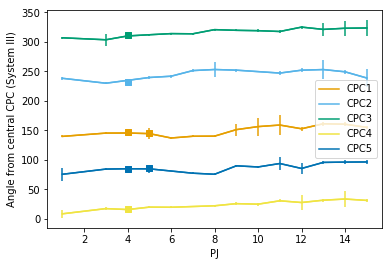

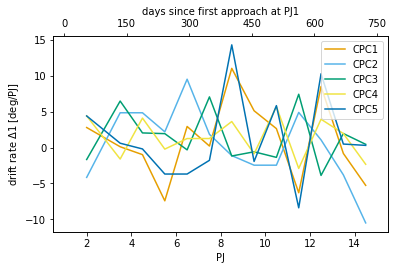

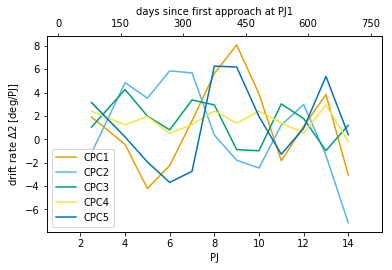

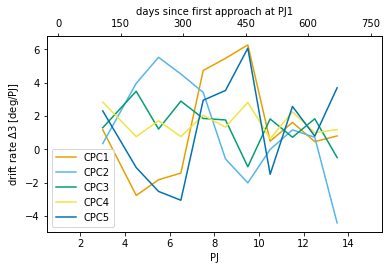

In [7]:
def plot_cpc_err3(df,dg,dferr,title='Angle from central CPC (System III)'):

    cols=df.columns.values.tolist()
    
    for i,col in enumerate(cols):
        df[col]  = df[col].interpolate() 
    dxx=df
    nc=len(dxx['CPC1'].values[:])
        
    x1=[]
    x2=[]
    x3=[]
    x4=[]
    x5=[]

    for i,col in enumerate(cols):
        x1.append((dxx[col].values[(0+1):nc]-dxx[col].values[0:-(0+1)])/(dxx.index[1:nc]-dxx.index[0:-(0+1)]))
        x2.append((dxx[col].values[(1+1):nc]-dxx[col].values[0:-(1+1)])/(dxx.index[2:nc]-dxx.index[0:-(1+1)]))
        x3.append((dxx[col].values[(2+1):nc]-dxx[col].values[0:-(2+1)])/(dxx.index[3:nc]-dxx.index[0:-(2+1)]))
        x4.append((dxx[col].values[(3+1):nc]-dxx[col].values[0:-(3+1)])/(dxx.index[4:nc]-dxx.index[0:-(3+1)]))
        x5.append((dxx[col].values[(4+1):nc]-dxx[col].values[0:-(4+1)])/(dxx.index[5:nc]-dxx.index[0:-(4+1)]))
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    colors = c8[1:8] # list(mcolors.BASE_COLORS)
    
    for icol, col in enumerate(cols):    
        ax1.plot(df[col],color=colors[icol])  
        ax1.errorbar(df.index, df.iloc[:,icol].values, yerr=dferr.iloc[:,icol].values,color=colors[icol])
        ax1.scatter(dg.index, dg.iloc[:,icol].values,color=colors[icol],marker='s')
        
        
    ax1.set_ylabel(title)
    ax1.set_xlabel('PJ') 
    ax1.legend(cols,loc=0)   

    j=0
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    ax1.set_ylabel(r'drift rate $\Delta$1 [deg/PJ]')
    ax1.set_xlabel('PJ') 
    colors = c8[1:8] # list(mcolors.BASE_COLORS)
    
    for i,col in enumerate(cols):
        index=(dxx.index[1:nc]+dxx.index[0:-1])/2
        xplot=x1[i]
        imask = np.isfinite(xplot)
        ax1.plot(index[imask],xplot[imask],color=colors[i])
    ax1.legend(cols,loc=0) 
    ax2=make_day_axis(ax1,fig1)
    fig1.savefig('drift_Del1.png')
    
    j=1
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    ax1.set_ylabel(r'drift rate $\Delta$2 [deg/PJ]')
    ax1.set_xlabel('PJ') 
    colors = c8[1:8] # list(mcolors.BASE_COLORS)
    
    for i,col in enumerate(cols):
        index=(dxx.index[(j+1):nc]+dxx.index[0:-(j+1)])/2
        xplot=x2[i]
        imask = np.isfinite(xplot)
        ax1.plot(index[imask],xplot[imask],color=colors[i])
    ax1.legend(cols,loc=0) 
    ax2=make_day_axis(ax1,fig1)
    fig1.savefig('drift_Del2.png') 
        
    j=2
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    ax1.set_ylabel(r'drift rate $\Delta$3 [deg/PJ]')
    ax1.set_xlabel('PJ') 
    colors = c8[1:8] # list(mcolors.BASE_COLORS)
    for i,col in enumerate(cols):
        index=(dxx.index[(j+1):nc]+dxx.index[0:-(j+1)])/2
        xplot=x3[i]
        imask = np.isfinite(xplot)
        ax1.plot(index[imask],xplot[imask],color=colors[i])
    ax1.legend(cols,loc=0) 
    ax2=make_day_axis(ax1,fig1)
    fig1.savefig('drift_Del3.png',dpi=200)


plot_cpc_err3(make_n(dx,'location == "angle from CPC0"'),dg5,make_n(dx,'location == "error angle from CPC0"'),title='Angle from central CPC (System III)')
#plot_cpc_err3(make_n(dx,'location == "angle from pole"'),dg6,make_n(dx,'location == "error angle from pole"'),title='Angle from Pole (System III)')


[0.03333333 0.22       0.40666667 0.59333333 0.78       0.96666667]
[0.03333333 0.22       0.40666667 0.59333333 0.78       0.96666667]
[0.03333333 0.22       0.40666667 0.59333333 0.78       0.96666667]
[0.03333333 0.22       0.40666667 0.59333333 0.78       0.96666667]
[0.03333333 0.22       0.40666667 0.59333333 0.78       0.96666667]


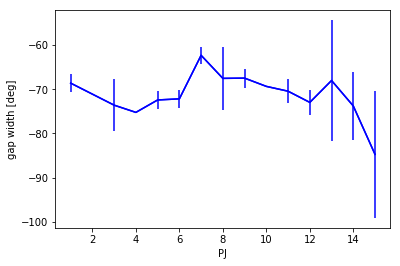

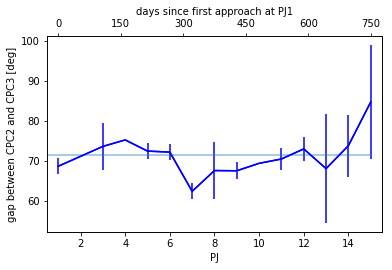

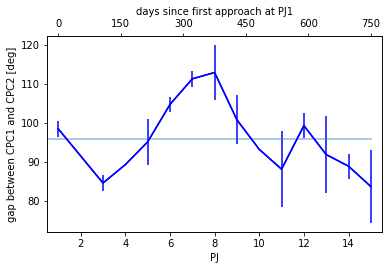

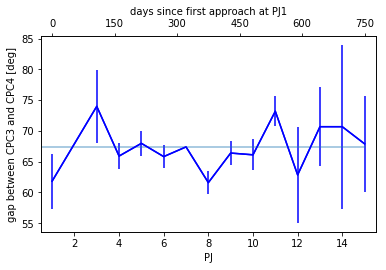

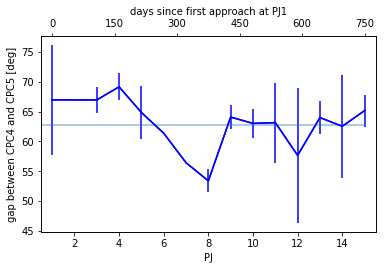

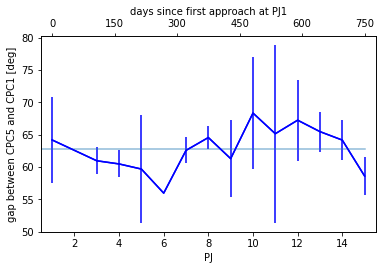

In [8]:
#GAPGAPGAPGAPGAPS

dxx=make_n(dx,'location == "angle from CPC0"')
df7=dxx.copy()
cols=dxx.columns.values.tolist()

for i,col in enumerate(cols):
    df7[col]  = dxx[col].interpolate() 

df8=df7.copy()
#for i,col in enumerate(cols):
    #print((df7[col].values[(0+1):-1]-df7[col].values[0:-(0+2)])/(df7.index[1:-1]-df7.index[0:-(0+2)]))
    
#df7
gap=df7['CPC2']-df7['CPC3']
err=make_n(dx,'location == "error angle from CPC0"')
gaperr=(err['CPC2']+err['CPC3'])/2
#gap.plot()
#gaperr.plot()
#gap.values, gaperr.values

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.set_ylabel('gap width [deg]')
ax1.set_xlabel('PJ') 
colors = list(mcolors.BASE_COLORS)
ax1.plot(gap,color=colors[0])  
ax1.errorbar(gap.index, gap.values, yerr=gaperr.values,color=colors[0])  

mean=gap.mean()
#print(mean)
#OTHER GAPS

def plotgap(df,err,CPC1,CPC2):
    gap=df7[CPC2]-df7[CPC1]
    if gap[1]<0: gap=gap+360
    mean=gap.mean()
    gaperr=(err[CPC1]+err[CPC2])/2
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    ax1.set_ylabel('gap between '+CPC1+' and '+CPC2+' [deg]')
    ax1.set_xlabel('PJ') 
    colors = list(mcolors.BASE_COLORS)
    ax1.plot(gap,color=colors[0])  
    ax1.plot(16*[mean],alpha=0.5)
    ax1.errorbar(gap.index, gap.values, yerr=gaperr.values,color=colors[0]) 
    ax2=make_day_axis(ax1,fig1)
    fig1.savefig('gap_'+CPC1+CPC2+'.png')
    
err=make_n(dx,'location == "error angle from CPC0"')
plotgap(df7,err,'CPC2','CPC3')
plotgap(df7,err,'CPC1','CPC2')
plotgap(df7,err,'CPC3','CPC4')
plotgap(df7,err,'CPC4','CPC5')
plotgap(df7,err,'CPC5','CPC1')


          CPC0        CPC1        CPC2        CPC3       CPC4        CPC5
PJ                                                                       
1   225.125165  158.485246  234.630102  289.102623  -3.102868   88.320170
3   244.486130  157.360857  232.328520  294.496153   8.673174   88.661557
4   207.699473  154.015629         NaN  298.590384  12.994617   94.155214
5   203.979434  156.092282  232.054937  296.221156  18.376265   98.081945
6   218.290163  157.959028  234.526388  289.735164   9.771747         NaN
7   216.193207  161.363069  240.632497  290.912548        NaN   96.527841
8   231.340192  159.979652  246.825677  299.884287   9.462322   85.601295
9   245.157611  164.645582  250.401189  306.515678  15.910028   96.458816
10  210.256437  162.875510         NaN  310.255101  23.891092   95.644622
11  220.763605  169.230012  242.189585  304.695154  28.134406  103.348727
12  213.943587  167.828542  241.681544  304.800671  24.655899  101.567440
13  225.000000  175.794643  245.854458

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


5.584002156920256
14 14
[0.03333333 0.22       0.40666667 0.59333333 0.78       0.96666667]
6.030955445939933
14 14
[0.03333333 0.22       0.40666667 0.59333333 0.78       0.96666667]
6.542992713851886
14 14
[0.03333333 0.22       0.40666667 0.59333333 0.78       0.96666667]
6.540231879185624
14 14
[0.03333333 0.22       0.40666667 0.59333333 0.78       0.96666667]


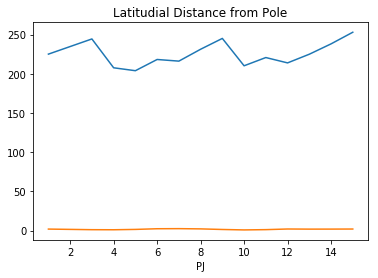

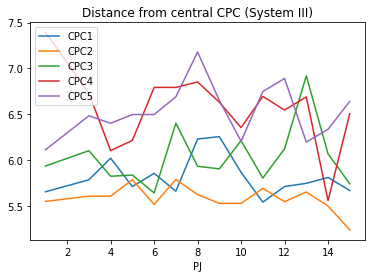

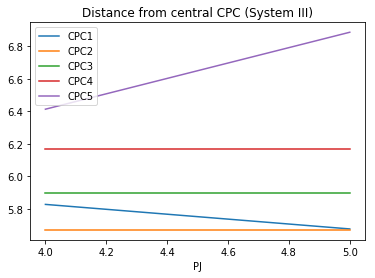

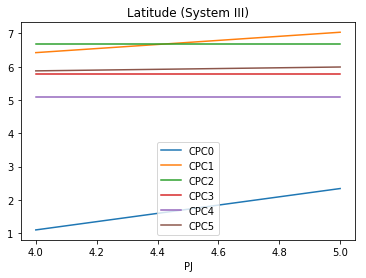

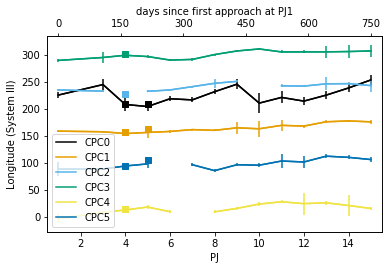

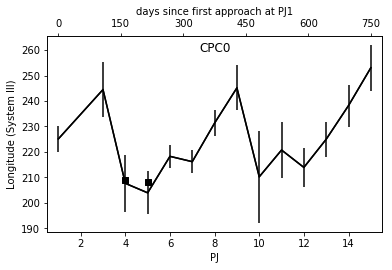

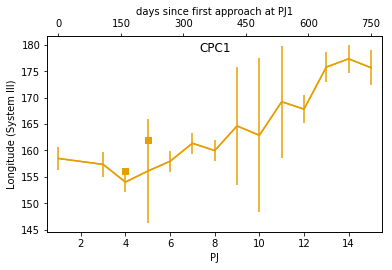

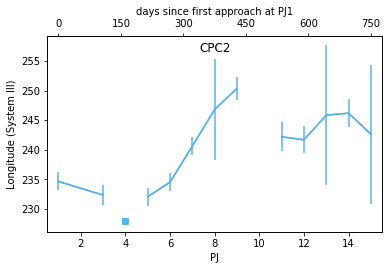

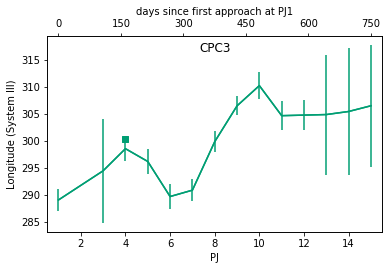

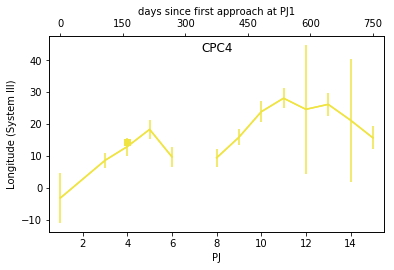

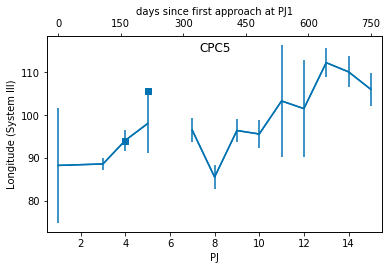

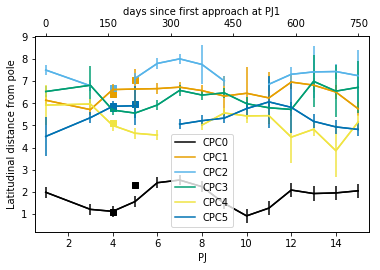

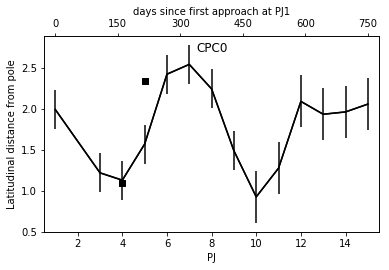

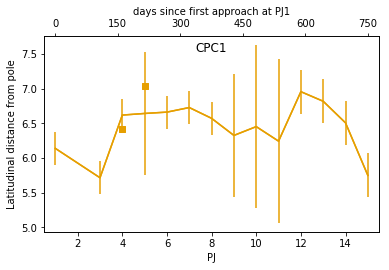

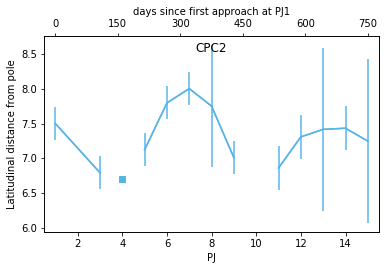

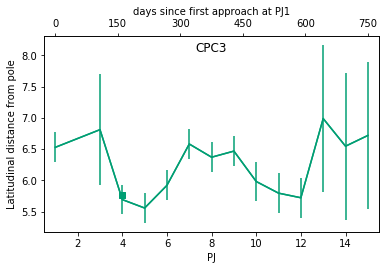

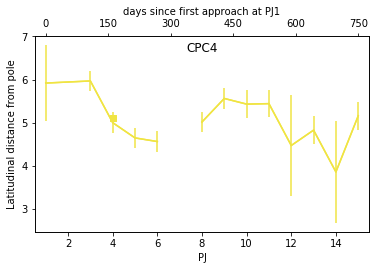

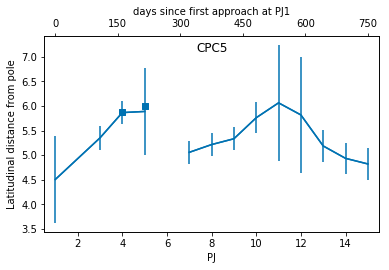

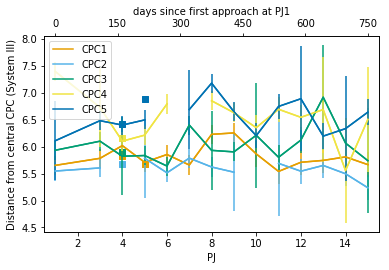

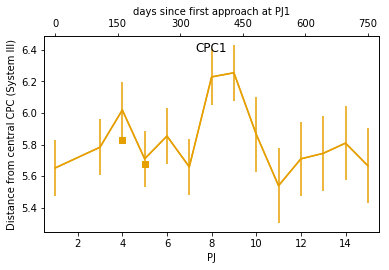

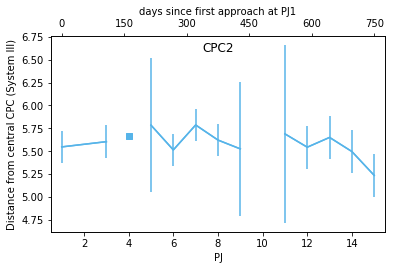

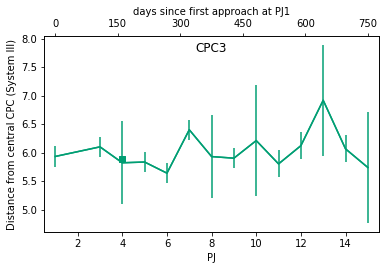

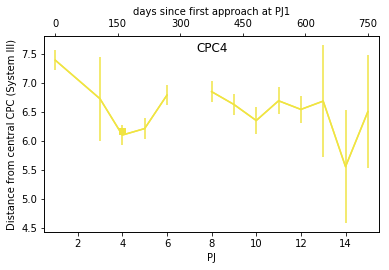

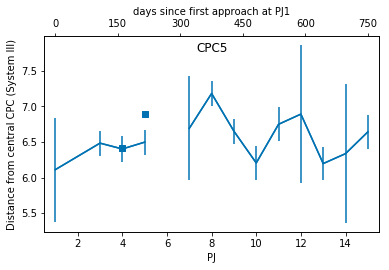

In [10]:
import matplotlib.transforms as mtransforms

def plot_cpc_err0(df,dg,dferr,title='Angle from central CPC (System III)',name=''):

    cols=df.columns.values.tolist()

    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    colors = c8[1:8] # list(mcolors.BASE_COLORS)
    print(colors)
    if name=='_frompole' or name=='_angle_frompole' or name=='_dist_frompole' : 
        colors = c8 # ['k','b', 'g', 'r', 'c', 'm']
    else:
        colors = c8[1:8] # ['b', 'g', 'r', 'c', 'm']
    #colors = 5*['k']#colors[5:]
    
    #print(df)
    #print(dg)
    #print(dferr)
    #print(dferr.iloc[:,1].values)
    
    for icol, col in enumerate(cols):    
        ax1.plot(df[col],color=colors[icol])  
        ax1.errorbar(df.index, df.iloc[:,icol].values, yerr=dferr.iloc[:,icol].values,color=colors[icol])
        ax1.scatter(dg.index, dg.iloc[:,icol].values,color=colors[icol],marker='s')
        
        
    ax1.set_ylabel(title)
    ax1.set_xlabel('PJ') 
    ax1.legend(cols,loc=0)   
        #(dg5[~dg5['CPC1'].isnull()]).plot.scatter()
        #ax1.scatter(dg5[~dg5['CPC1'].isnull()])
    ax2=make_day_axis(ax1,fig1)
    fig1.savefig('0CPC_all'+name+'.png',dpi=200)
    #print(df)
    #print(dg)
    #cols=cols[0:1]
    for icol, col in enumerate(cols):
        fig1 = plt.figure()
        ax1 = fig1.add_subplot(111)
        ax1.plot(df[col],color=colors[icol])
        print(np.mean(df[col]))
        ax1.scatter(dg.index, dg.iloc[:,icol].values,color=colors[icol],marker='s')
        print(len(df.iloc[:,icol].values),len(dferr.iloc[:,icol].values))
        ax1.errorbar(df.index, df.iloc[:,icol].values, yerr=dferr.iloc[:,icol].values,color=colors[icol])
        #v_drift = (df[col].values[-1]-df[col].values[0])/(df.index[-1]-1)
        #ax1.set_title(col+r' $v_{drift}=$'+str(round(v_drift,2)))
        ax1.set_ylabel(title)
        ax1.set_title(col)
        ax1.set_xlabel('PJ')
        ax2=make_day_axis(ax1,fig1)
        fig1.savefig('0CPC_'+col+name+'.png',dpi=200)
    
    


        
        
        
        
df0=df3.query('location == "angle from pole"').copy()
df0=df0.drop(columns=['pole'])
df0[df0>340]-=360
df0=df0.reset_index()
df0=df0.drop(columns=['location'])
#df4=df4.drop(columns=['index'])
df0=df0.set_index('PJ')
print(df0)
df0.fillna(method='ffill')['CPC0'].plot()
plt.title('Longitude (System III)')


df0x=df3.query('location == "distance from pole"').copy()
df0x=df0x.drop(columns=['pole'])
df0x[df0x>340]-=360
df0x=df0x.reset_index()
df0x=df0x.drop(columns=['location'])
#df4=df4.drop(columns=['index'])
df0x=df0x.set_index('PJ')
print(df0)
df0x.fillna(method='ffill')['CPC0'].plot()
plt.title('Latitudial Distance from Pole')

df5x=df3.query('location == "distance from CPC0"').copy()
df5x=df5x.drop(columns=['pole'])
df5x=df5x.drop(columns=['CPC0'])
df5x[df5x>340]-=360
df5x=df5x.reset_index()
df5x=df5x.drop(columns=['location'])
df5x=df5x.set_index('PJ')
df5x.fillna(method='ffill').plot()
plt.title('Distance from central CPC (System III)')

dg5x=dg3.query('location == "distance from CPC0"').copy()
dg5x=dg5x.drop(columns=['pole'])
dg5x=dg5x.drop(columns=['CPC0'])
dg5x[dg5x>340]-=360
dg5x=dg5x.reset_index()
dg5x=dg5x.drop(columns=['location'])
dg5x=dg5x.set_index('PJ')
dg5x.fillna(method='ffill').plot()
#df5.fillna(method='ffill').plot()
plt.title('Distance from central CPC (System III)')

dg0x=dg3.query('location == "distance from pole"').copy()
dg0x=dg0x.drop(columns=['pole'])
dg0x[dg0x>340]-=360
dg0x=dg0x.reset_index()
dg0x=dg0x.drop(columns=['location'])
dg0x=dg0x.set_index('PJ')
dg0x.fillna(method='ffill').plot()
#df5.fillna(method='ffill').plot()
plt.title('Latitude (System III)')

#print('test')
#print(make_n(dx0,'location == "error distance from pole"'))

plot_cpc_err0(df0,dg0,make_n(dx0,'location == "error angle from pole"'),title='Longitude (System III)',name='_angle_frompole')
plot_cpc_err0(df0x,dg0x,make_n(dx0,'location == "error distance from pole"'),title='Latitudinal distance from pole',name='_dist_frompole')
plot_cpc_err0(df5x,dg5x,make_n(dx0,'location == "error distance from CPC0"'),title='Distance from central CPC (System III)',name='_dist_fromCPC0')

#plot_cpc_err0(df0x,dg0x,make_n(dx0,'location == "error distance from pole"'),title='Distance from South Pole (System III)',name='_dist_frompole')



In [69]:
for a in df0['CPC0'].index: print(a)

1
3
4
5
6
7
8
9
10
11
12
13
14
15


In [70]:
df0['CPC0'].iloc[0]

225.12516521943067

['#000000', '#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7']


/usr/local/lib/python3.7/site-packages/matplotlib/projections/polar.py:67: RuntimeWarning: invalid value encountered in less
  mask = r < 0


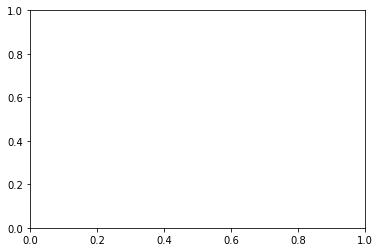

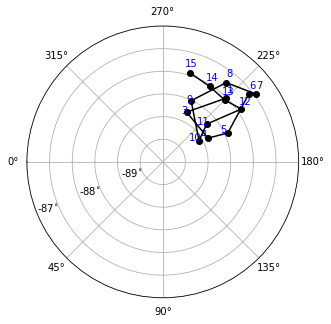

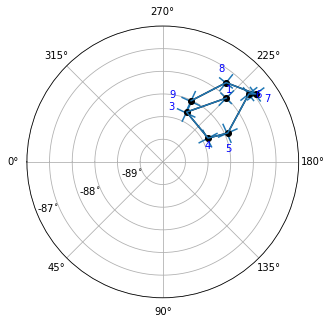

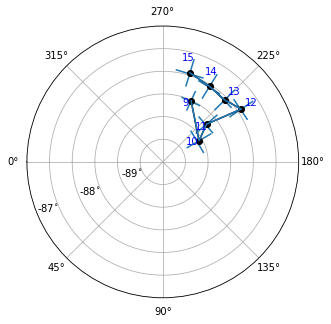

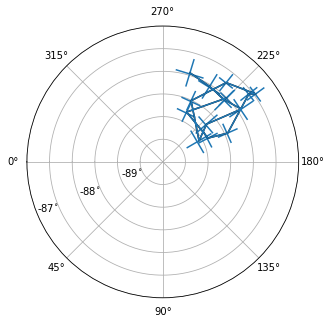

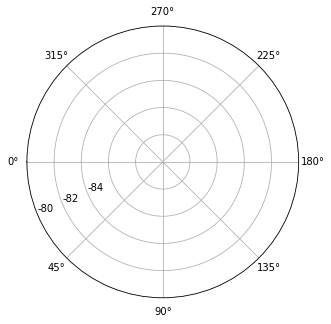

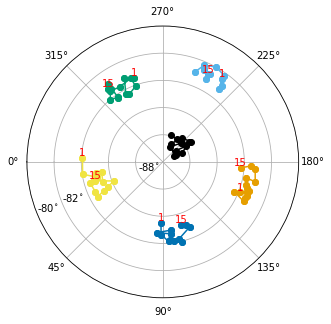

In [71]:
def plot_cpc_polar(dfa,dfd,dfaerr,dfderr,title='Angle from central CPC (System III)',name=''):

    cols=dfa.columns.values.tolist()
    #col='CPC0'
    
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    colors = c8 # list(mcolors.BASE_COLORS)
    cx = ['k', 'b', 'g', 'r', 'c', 'm']  #list(mcolors.BASE_COLORS)
    print(colors)
    if name=='_frompole' or name=='_angle_frompole' or name=='_dist_frompole' : 
        colors = c8 # ['k','b', 'g', 'r', 'c', 'm']
    else:
        colors = c8[1:8] # ['b', 'g', 'r', 'c', 'm']   

    fig1 = plt.figure(figsize=(5,5)) 
    ax1 = fig1.add_subplot(111, polar=True)
    trans_offset = mtransforms.offset_copy(ax1.transData, fig=fig1,
                                y=4, units='dots')
    ax1.set_theta_zero_location("W")
    ax1.set_ylim([0,2.6])
    ax1.set_ylim([0,3])
    ax1.set_yticklabels(['',r'-89$\!^\circ$','',r'-88$\!^\circ$','',r'-87$\!^\circ$'])
    plt.polar(dfa['CPC0']*np.pi/180,dfd['CPC0'],color=colors[0])
    #print(cols)
    for i,pj in enumerate(dfa['CPC0'].index):
        #print(i,pj)
        #print(dfd['CPC0'].iloc[i])
        #print(dfd['CPC0'].iloc[i])
        thisr, thistheta = dfd['CPC0'].iloc[i], dfa['CPC0'].iloc[i]*np.pi/180
        ax1.plot([thistheta], [thisr], 'o',color=colors[0])
        ax1.annotate(str(pj),
                xy=(thistheta, thisr),  # theta, radius
                xytext=(thistheta,  thisr+0.1*np.sign(thisr-1.7)),    # fraction, fraction
                textcoords='data',
                #arrowprops=dict(facecolor='black', shrink=0.05),
                horizontalalignment='center',
                verticalalignment='bottom',color=cx[1]
                )        
    fig1.savefig('pCPC_'+'CPC0'+'_loc_polar'+name+'.png',dpi=200)

      
    fig1 = plt.figure(figsize=(5,5)) 
    ax1 = fig1.add_subplot(111, polar=True)
    trans_offset = mtransforms.offset_copy(ax1.transData, fig=fig1,
                                y=4, units='dots')
    ax1.set_theta_zero_location("W")
    ax1.set_ylim([0,3])
    ax1.set_yticklabels(['',r'-89$\!^\circ$','',r'-88$\!^\circ$','',r'-87$\!^\circ$'])
    plt.polar(dfa['CPC0'].iloc[0:8]*np.pi/180,dfd['CPC0'].iloc[0:8],color=colors[0])
    ax1.errorbar(dfa['CPC0'].iloc[0:8]*np.pi/180,dfd['CPC0'].iloc[0:8], xerr=dfaerr['CPC0'].iloc[0:8]*np.pi/180, yerr=dfderr['CPC0'].iloc[0:8], capsize=0)
    #print(cols)
    for i,pj in enumerate(dfa['CPC0'].index[0:8]):
        #print(i,pj)
        #print(dfd['CPC0'].iloc[i])
        #print(dfd['CPC0'].iloc[i])
        thisr, thistheta = dfd['CPC0'].iloc[i], dfa['CPC0'].iloc[i]*np.pi/180
        ax1.plot([thistheta], [thisr], 'o',color=colors[0])
        ax1.annotate(str(pj),
                xy=(thistheta, thisr),  # theta, radius
                xytext=(thistheta+0.8*(thistheta-225/180*np.pi), thisr+0.1*np.sign(thisr-1.7)),    # fraction, fraction
                textcoords='data',
                #arrowprops=dict(facecolor='black', shrink=0.05),
                horizontalalignment='center',
                verticalalignment='bottom',color=cx[1]
                )        
    fig1.savefig('pCPC_'+'CPC0'+'_loc_polar'+name+'x1_error.png',dpi=200)

    fig1 = plt.figure(figsize=(5,5)) 
    ax1 = fig1.add_subplot(111, polar=True)
    trans_offset = mtransforms.offset_copy(ax1.transData, fig=fig1,
                                y=4, units='dots')
    ax1.set_theta_zero_location("W")
    ax1.set_ylim([0,2.6])
    ax1.set_ylim([0,3])
    ax1.set_yticklabels(['',r'-89$\!^\circ$','',r'-88$\!^\circ$','',r'-87$\!^\circ$'])
    plt.polar(dfa['CPC0'].iloc[7:npj]*np.pi/180,dfd['CPC0'].iloc[7:npj],color=colors[0])
    ax1.errorbar(dfa['CPC0'].iloc[7:npj]*np.pi/180,dfd['CPC0'].iloc[7:npj], xerr=dfaerr['CPC0'].iloc[7:npj]*np.pi/180, yerr=dfderr['CPC0'].iloc[7:npj], capsize=0)
    #print(cols)
    for i,pj in enumerate(dfa['CPC0'].index[7:npj], start=7):
        #print(i,pj)
        #print(dfd['CPC0'].iloc[i])
        #print(dfd['CPC0'].iloc[i])
        thisr, thistheta = dfd['CPC0'].iloc[i], dfa['CPC0'].iloc[i]*np.pi/180
        ax1.plot([thistheta], [thisr], 'o',color=colors[0])
        ax1.annotate(str(pj),
                xy=(thistheta, thisr),  # theta, radius
                xytext=(thistheta+0.04*np.sign(thistheta-230/180*np.pi), thisr+0.2*np.sign(thisr-1.7)),    # fraction, fraction
                textcoords='data',
                #arrowprops=dict(facecolor='black', shrink=0.05),
                horizontalalignment='center',
                verticalalignment='bottom',color=cx[1]
                )        
    fig1.savefig('pCPC_'+'CPC0'+'_loc_polar'+name+'x2_error.png',dpi=200)    
    

    
    fig1 = plt.figure(figsize=(5,5)) 
    ax1 = fig1.add_subplot(111, polar=True)
    trans_offset = mtransforms.offset_copy(ax1.transData, fig=fig1,
                                y=4, units='dots')
    ax1.set_theta_zero_location("W")
    ax1.set_ylim([0,3])
    ax1.set_yticklabels(['',r'-89$\!^\circ$','',r'-88$\!^\circ$','',r'-87$\!^\circ$'])
    for icol, col in enumerate([cols[0]]):
        plt.polar(dfa[col]*np.pi/180,dfd[col],color=colors[icol])
        ax1.errorbar(dfa[col]*np.pi/180,dfd[col], xerr=dfaerr[col]*np.pi/180, yerr=dfderr[col], capsize=0)
        #print(cols)
        #for i,pj in enumerate(dfa[col].index):
        #    print(i,pj)
        #    #print(dfd[col].iloc[i])
        #    #print(dfd[col].iloc[i])
        #    thisr, thistheta = dfd[col].iloc[i], dfa[col].iloc[i]*np.pi/180
        #    ax1.plot([thistheta], [thisr], 'o',color=colors[icol])
        #    ax1.annotate(str(pj),
        #            xy=(thistheta, thisr),  # theta, radius
        #            xytext=(thistheta, thisr+0.1),    # fraction, fraction
        #            textcoords='data',
        #            #arrowprops=dict(facecolor='black', shrink=0.05),
        #            horizontalalignment='center',
        #            verticalalignment='bottom'
        #            )        
    fig1.savefig('pCPC_'+'CPC0'+'_loc_polar'+name+'_error.png',dpi=200)
    
    
    fig1 = plt.figure(figsize=(5,5)) 
    ax1 = fig1.add_subplot(111, polar=True)
    trans_offset = mtransforms.offset_copy(ax1.transData, fig=fig1,
                                y=4, units='dots')
    ax1.set_theta_zero_location("W")
    ax1.set_ylim(0,10)
    ax1.set_yticklabels(['','','-84','-82','-80'])
    fig1.savefig('pCPC_example.png',dpi=400)
    
    fig1 = plt.figure(figsize=(5,5)) 
    ax1 = fig1.add_subplot(111, polar=True)
    trans_offset = mtransforms.offset_copy(ax1.transData, fig=fig1,
                                y=4, units='dots')
    ax1.set_theta_zero_location("W")
    ax1.set_ylim(0,10)
    ax1.set_yticklabels([r'-88$\!^\circ$','','',r'-82$\!^\circ$',r'-80$\!^\circ$'])
    for icol, col in enumerate(cols):
        plt.polar(dfa[col]*np.pi/180,dfd[col],color=colors[icol],marker='o')   
    
    for cpc in ['CPC1']:
        for i,pj in enumerate(dfa[cpc].index[0:npj]):
        #print(i,pj)
        #print(dfd['CPC0'].iloc[i])
        #print(dfd['CPC0'].iloc[i])
        
            thisr, thistheta = dfd[cpc].iloc[i], dfa[cpc].iloc[i]*np.pi/180
            plt.plot([thistheta], [thisr], 'o',color=colors[1])
            if pj==1 or pj ==2 or pj==15 or pj==15:
                ax1.annotate(str(pj),
                    xy=(thistheta, thisr),  # theta, radius
                    xytext=(thistheta, thisr),    # fraction, fraction
                    textcoords='data',
                    #arrowprops=dict(facecolor='black', shrink=0.05),
                    horizontalalignment='center',
                    verticalalignment='bottom',color=cx[3]
                    )  
    for cpc in ['CPC2']:
        for i,pj in enumerate(dfa[cpc].index[0:npj]):
        #print(i,pj)
        #print(dfd['CPC0'].iloc[i])
        #print(dfd['CPC0'].iloc[i])
        
            thisr, thistheta = dfd[cpc].iloc[i], dfa[cpc].iloc[i]*np.pi/180
            plt.plot([thistheta], [thisr], 'o',color=colors[2])
            if pj==1 or pj ==2 or pj==15 or pj==15:
                ax1.annotate(str(pj),
                    xy=(thistheta, thisr),  # theta, radius
                    xytext=(thistheta, thisr),    # fraction, fraction
                    textcoords='data',
                    #arrowprops=dict(facecolor='black', shrink=0.05),
                    horizontalalignment='center',
                    verticalalignment='bottom',color=cx[3]
                    )
    for cpc in ['CPC3']:
        for i,pj in enumerate(dfa[cpc].index[0:npj]):
        #print(i,pj)
        #print(dfd['CPC0'].iloc[i])
        #print(dfd['CPC0'].iloc[i])
        
            thisr, thistheta = dfd[cpc].iloc[i], dfa[cpc].iloc[i]*np.pi/180
            plt.plot([thistheta], [thisr], 'o',color=colors[3])
            if pj==1 or pj ==2 or pj==15 or pj==15:
                ax1.annotate(str(pj),
                    xy=(thistheta, thisr),  # theta, radius
                    xytext=(thistheta, thisr),    # fraction, fraction
                    textcoords='data',
                    #arrowprops=dict(facecolor='black', shrink=0.05),
                    horizontalalignment='center',
                    verticalalignment='bottom',color=cx[3]
                    )
                
    for cpc in ['CPC4']:
        for i,pj in enumerate(dfa[cpc].index[0:npj]):
        #print(i,pj)
        #print(dfd['CPC0'].iloc[i])
        #print(dfd['CPC0'].iloc[i])
        
            thisr, thistheta = dfd[cpc].iloc[i], dfa[cpc].iloc[i]*np.pi/180
            plt.plot([thistheta], [thisr], 'o',color=colors[4])
            if pj==1 or pj ==2 or pj==15 or pj==15:
                ax1.annotate(str(pj),
                    xy=(thistheta, thisr),  # theta, radius
                    xytext=(thistheta, thisr),    # fraction, fraction
                    textcoords='data',
                    #arrowprops=dict(facecolor='black', shrink=0.05),
                    horizontalalignment='center',
                    verticalalignment='bottom',color=cx[3]
                    )
    for cpc in ['CPC5']:
        for i,pj in enumerate(dfa[cpc].index[0:npj]):
        #print(i,pj)
        #print(dfd['CPC0'].iloc[i])
        #print(dfd['CPC0'].iloc[i])
        
            thisr, thistheta = dfd[cpc].iloc[i], dfa[cpc].iloc[i]*np.pi/180
            plt.plot([thistheta], [thisr], 'o',color=colors[5])
            if pj==1 or pj ==2 or pj==15 or pj==15:
                ax1.annotate(str(pj),
                    xy=(thistheta, thisr),  # theta, radius
                    xytext=(thistheta, thisr),    # fraction, fraction
                    textcoords='data',
                    #arrowprops=dict(facecolor='black', shrink=0.05),
                    horizontalalignment='center',
                    verticalalignment='bottom',color=cx[3]
                    )
                
    fig1.savefig('pCPC_'+'all'+'_loc_polar'+name+'_all.png',dpi=200)
    
    
    
plot_cpc_polar(df0,df0x,make_n(dx0,'location == "error angle from pole"'),make_n(dx0,'location == "error distance from pole"'),title='Location of SPC center',name='_frompole')

frames = [df0, 90-df0x,make_n(dx0,'location == "error angle from pole"'),make_n(dx0,'location == "error distance from pole"')]
result = ps.concat(frames, keys=['lon', 'lat', 'lon_err','lat_err'])
#result=result.sort_index()
#result=result.reset_index()
#result=result.set_index('PJ')
#result=result.rename(index=str, columns={"level_0": "coord"})
#result=result.sort_values(by=['coord'])
#result=result.sort_index()
#result=result.sort_index(level=3)
result=result.sort_values(by=['PJ'])
result=result.sort_index()
#    df4=df4.reset_index()
#    df4=df4.drop(columns=['location'])
#    #df4=df4.drop(columns=['index'])
#    df4=df4.set_index('PJ')
#result

In [72]:
cols[0]

'CPC1'